In [1]:
# just using the bounding box


#### get png and json filepaths

import glob
import os
import re
from PIL import Image

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)


# remove redundant files
png_files_new = []

for png in png_files:
    if png[-5] == ')':
        continue
    else:
        png_files_new.append(png)
png_files = png_files_new

json_files_new = []

for json in json_files:
    if json[-6] == ')':
        continue
    else:
        json_files_new.append(json)
json_files = json_files_new

print(len(png_files), len(json_files))
min_length = min(len(png_files), len(json_files))
png_files = png_files[:min_length]
json_files = json_files[:min_length]

# png_files.sort(key=extract_png_number)
# json_files.sort(key=extract_json_number)

for i in range(len(png_files)):
    assert png_files[i][-5] == json_files[i][-6], 'file mismatch'

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['translation'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data


def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin
    return height, width, ymin, ymax, xmin, xmax


dimensions = []
for png_f in png_files:
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    dimensions.append(model_dimensions(img_np))
dimensions = np.array(dimensions, dtype=np.float32)
xvals = dimensions


# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))

n = len(xvals[:n_pts_to_train])
n_train = int(data_percent*n)
n_test = n - n_train
print(n, n_train, n_test)

indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]


10000 10000
7000 4900 2100


l2 score on test, Extra trees 2.1066469662723772


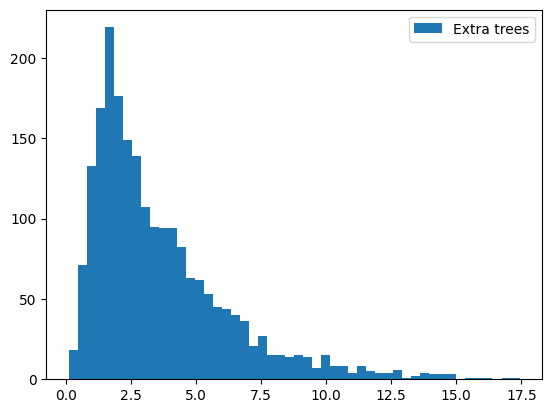

l2 score on test, K-nn 2.1967113


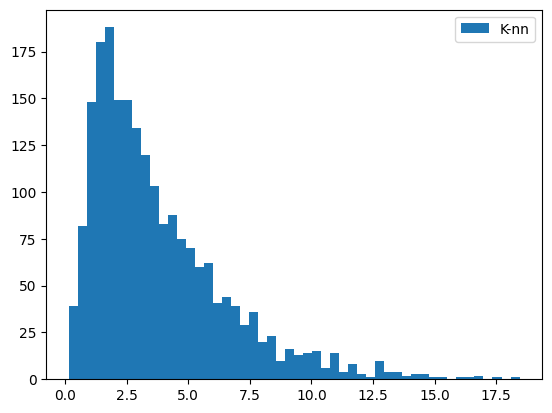

l2 score on test, Ridge 2.5299833630124136


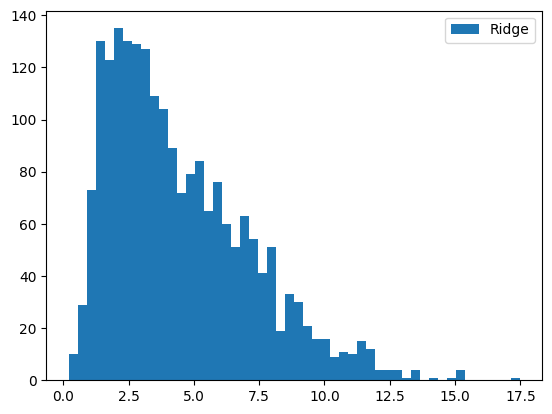

l2 score on test, Linear Regression 2.5299833


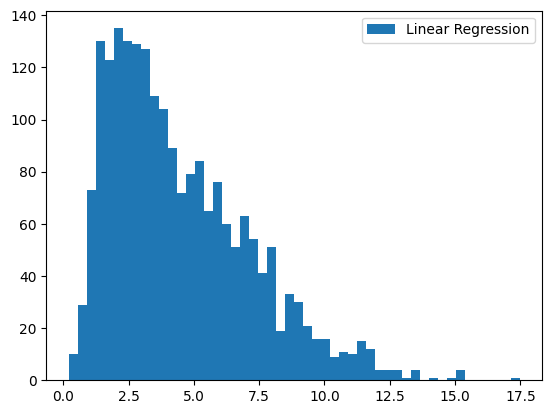

l2 score on test, Lasso Linear_0.01 2.5299735


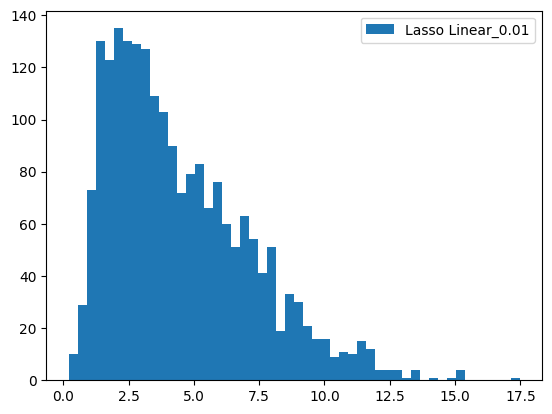

l2 score on test, Lasso Linear_0.1 2.5298955


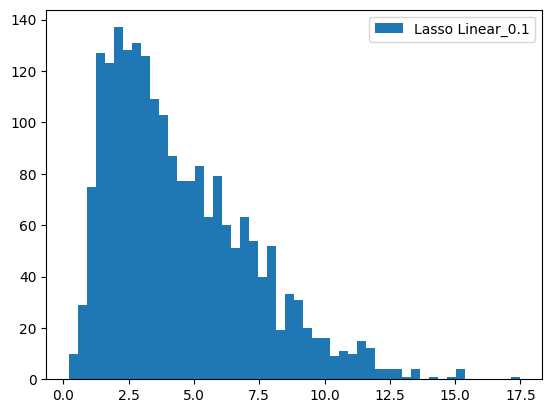

l2 score on test, Lasso Linear_0.5 2.529659


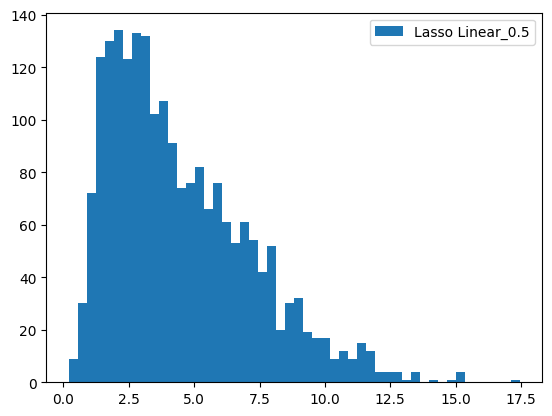

In [2]:
# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    plt.hist(l2(y_vals[test_indices], y_test_predict[name]), bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


In [3]:
# LINEAR REGRESSOR 

In [4]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

estimator = ESTIMATORS['Extra trees']
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)


In [5]:
# quartiles
l2_scores = l2(y_vals[test_indices], y_test_predict[test_indices])
print(np.quantile(l2_scores, [0,0.25,0.5,0.75,1]))
print(l2_scores.mean())


[ 0.10031836  1.69630316  2.83374615  4.75764493 17.43094931]
3.6122889693336426


l2 score on test, Linear Regression 2.5299833


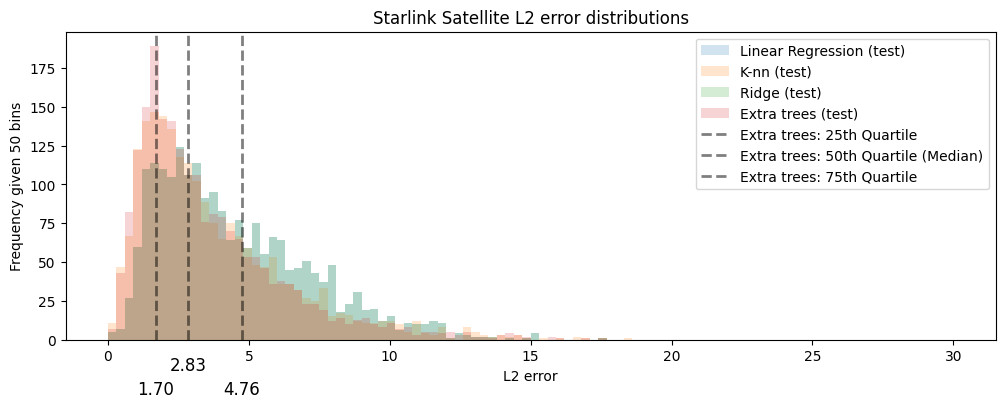

[ 0.10031836  1.69630316  2.83374615  4.75764493 17.43094931]
3.6122889693336426


In [6]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)


plt.figure(figsize=(12,4))

########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 30
bin_width = 0.3  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)




name = 'Linear Regression'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[test_indices], squared=False))
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'K-nn'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'Ridge'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'Extra trees'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

# name = 'Lasso Linear_0.01'
# estimator = ESTIMATORS[name]
# estimator.fit(xvals[train_indices], y_vals[train_indices])
# y_test_predict = estimator.predict(xvals)
# plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');


name = 'Extra trees'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
data = l2(y_vals[test_indices], y_test_predict[test_indices])
# Calculate QUARTILES values
q25 = np.percentile(data, 25)
q50 = np.percentile(data, 50)
q75 = np.percentile(data, 75)

# Add vertical lines for quartiles
plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 25th Quartile')
plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 50th Quartile (Median)')
plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 75th Quartile')

plt.text(q25, -35, f'{q25:.2f}', color='black', fontsize=12, ha='center')
plt.text(q50, -20, f'{q50:.2f}', color='black', fontsize=12, ha='center')
plt.text(q75, -35, f'{q75:.2f}', color='black', fontsize=12, ha='center')


plt.title('Starlink Satellite L2 error distributions')
plt.xlabel('L2 error')
plt.ylabel('Frequency given 50 bins')
plt.legend()
plt.show()

# quartiles
l2_scores = l2(y_vals[test_indices], y_test_predict[test_indices])
print(np.quantile(l2_scores, [0,0.25,0.5,0.75,1]))
print(l2_scores.mean())


In [7]:
#### WITH CUSTOM!!!

In [8]:
# just using the bounding box


#### get png and json filepaths

import glob
import os
import re
from PIL import Image

path = "/Users/dk/Documents.nosync/msc-project/boundingbox/starlink_random_10k/data"
png_files = glob.glob(os.path.join(path, '*.png'))
json_files = glob.glob(os.path.join(path, '*.json'))

def extract_png_number(filename):
    match = re.search(r'(\d+).png$', filename)
    if match:   return int(match.group(1))
    else:       return -1
    
def extract_json_number(filename):
    match = re.search(r'(\d+).json$', filename)
    if match:   return int(match.group(1))
    else:       return -1

png_files.sort(key=extract_png_number)
json_files.sort(key=extract_json_number)


# remove redundant files
png_files_new = []

for png in png_files:
    if png[-5] == ')':
        continue
    else:
        png_files_new.append(png)
png_files = png_files_new

json_files_new = []

for json in json_files:
    if json[-6] == ')':
        continue
    else:
        json_files_new.append(json)
json_files = json_files_new

print(len(png_files), len(json_files))
min_length = min(len(png_files), len(json_files))
png_files = png_files[:min_length]
json_files = json_files[:min_length]

# png_files.sort(key=extract_png_number)
# json_files.sort(key=extract_json_number)

for i in range(len(png_files)):
    assert png_files[i][-5] == json_files[i][-6], 'file mismatch'






    

## get the translations (YVALS) from the json files

import os
import json
import numpy as np

translations = []
for json_f in json_files:
    with open(json_f) as f: translations.append(json.load(f)['translation'])

translations = np.array(translations, dtype=np.float32)
y_vals = translations


# extract dimensions (XVALS) from the data

from skimage.color import rgb2gray
def model_dimensions(img_np:np.ndarray):

    # create object mask
    img_np_copy = img_np.copy()
    img_np_copy[np.where(img_np_copy<0.01)] = 0
    img_np_copy[np.where(img_np_copy>0.01)] = 1

    # determine object dimensions
    y,x,c = np.where(img_np_copy>0)
    try:
        ymin, ymax = np.min(y), np.max(y)
        xmin, xmax = np.min(x), np.max(x)
    except:
        ymin, ymax = 0, 0
        xmin, xmax = 0, 0
    height = ymax - ymin
    width = xmax - xmin

    # determine horizontal-wise pixel sums
    img_np_copy_bw = rgb2gray(img_np_copy.copy())
    horiz_sums = np.sum(img_np_copy_bw, axis=0)
    horiz_sums = horiz_sums/np.max(horiz_sums)
    horiz_sums = horiz_sums[horiz_sums>0.01]
    horiz_sums = [i for i in horiz_sums]

    # determine vertical-wise pixel sums
    vert_sums = np.sum(img_np_copy_bw, axis=1)
    vert_sums = vert_sums/np.max(vert_sums)
    vert_sums = vert_sums[vert_sums>0.01]
    vert_sums = [i for i in vert_sums]

    # turn the horizontal and vertical sums into a spline, and sample 20 points
    from scipy.interpolate import UnivariateSpline
    horiz_spline = UnivariateSpline(range(len(horiz_sums)), horiz_sums)
    vert_spline = UnivariateSpline(range(len(vert_sums)), vert_sums)
    horiz_spline.set_smoothing_factor(0.5)
    vert_spline.set_smoothing_factor(0.5)

    values_to_query = np.linspace(0, len(horiz_sums), 20)
    horiz_spline_vals = horiz_spline(values_to_query)

    values_to_query = np.linspace(0, len(vert_sums), 20)
    vert_spline_vals  = vert_spline(values_to_query)

    return [height, width, ymin, ymax, xmin, xmax] + list(horiz_spline_vals) + list(vert_spline_vals)



import tqdm
dimensions = []
dimensions_to_use = []
for png_f in tqdm.tqdm(png_files, desc='loading x vals'):
    img = Image.open(png_f).convert('RGB')
    img_np = np.array(img)/255.0
    try:
        dimensions.append(model_dimensions(img_np))
        dimensions_to_use.append(True)
    except:
        dimensions.append([0]*46)
        dimensions_to_use.append(False)
        continue

dimensions_to_use = np.array(dimensions_to_use, dtype='bool')
dimensions = np.array(dimensions, dtype=np.float32)
dimensions = dimensions[dimensions_to_use]
y_vals = y_vals[dimensions_to_use]
xvals = dimensions


# CHOOSE TRAINING AND TESTING INDICES

import random
random.seed(42)
data_percent = 0.7
n_pts_to_train = int(data_percent*len(xvals))

n = len(xvals[:n_pts_to_train])
n_train = int(data_percent*n)
n_test = n - n_train
print(n, n_train, n_test)

indices = list(range(n))
random.shuffle(indices)
train_indices = indices[:n_train]
test_indices = indices[n_train:]


10000 10000


loading x vals: 100%|██████████| 10000/10000 [02:28<00:00, 67.43it/s]


7000 4900 2100


In [ ]:
# other
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import sklearn
import matplotlib.pyplot as plt

# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(xvals[train_indices], y_vals[train_indices])
    y_test_predict[name] = estimator.predict(xvals[test_indices])
    print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[name], squared=False))
    plt.hist(l2(y_vals[test_indices], y_test_predict[name]), bins=50, alpha=1, label=name)
    plt.legend()
    plt.show()


In [10]:
# LINEAR REGRESSOR 

In [11]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)

estimator = ESTIMATORS['Extra trees']
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)


In [12]:
# quartiles
l2_scores = l2(y_vals[test_indices], y_test_predict[test_indices])
print(np.quantile(l2_scores, [0,0.25,0.5,0.75,1]))
print(l2_scores.mean())


[ 0.23983575  1.60611449  2.60693796  4.34808299 14.99436168]
3.32093081328015


l2 score on test, Linear Regression 2.4352572


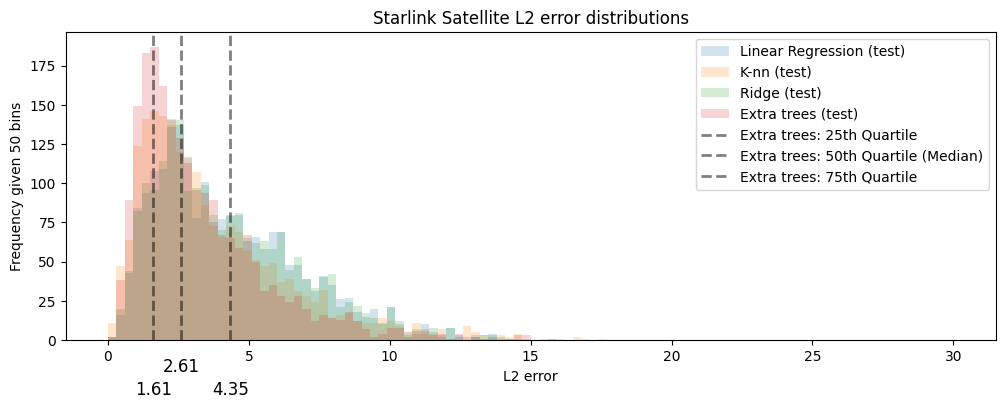

[ 0.23983575  1.60611449  2.60693796  4.34808299 14.99436168]
3.32093081328015


In [20]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt


# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(
        n_estimators=100, max_features=32, random_state=0
    ),
    "K-nn": KNeighborsRegressor(),
    "Ridge": RidgeCV(),
    "Linear Regression": LinearRegression(),
    "Lasso Linear_0.01": linear_model.LassoLars(alpha=0.01),
    "Lasso Linear_0.1": linear_model.LassoLars(alpha=0.1),
    "Lasso Linear_0.5": linear_model.LassoLars(alpha=0.5),
}

def l2(truth, pred):
    return np.linalg.norm(truth-pred, axis=1)


plt.figure(figsize=(12,4))

########## DEFINE BINS

# Define the desired bin edges (minimum and maximum values)
min_bin = 0
max_bin = 30
bin_width = 0.3  # Adjust this value as needed

# Calculate the number of bins based on the range and bin width
num_bins = int((max_bin - min_bin) / bin_width)




name = 'Linear Regression'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)

print(f'l2 score on test, {name}', sklearn.metrics.mean_squared_error(y_vals[test_indices], y_test_predict[test_indices], squared=False))
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'K-nn'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'Ridge'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

name = 'Extra trees'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');

# name = 'Lasso Linear_0.01'
# estimator = ESTIMATORS[name]
# estimator.fit(xvals[train_indices], y_vals[train_indices])
# y_test_predict = estimator.predict(xvals)
# plt.hist(l2(y_vals[test_indices], y_test_predict[test_indices]), bins=num_bins, range=(min_bin, max_bin), alpha=0.2, label=f'{name} (test)');


name = 'Extra trees'
estimator = ESTIMATORS[name]
estimator.fit(xvals[train_indices], y_vals[train_indices])
y_test_predict = estimator.predict(xvals)
data = l2(y_vals[test_indices], y_test_predict[test_indices])
# Calculate QUARTILES values
q25 = np.percentile(data, 25)
q50 = np.percentile(data, 50)
q75 = np.percentile(data, 75)

# Add vertical lines for quartiles
plt.axvline(q25, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 25th Quartile')
plt.axvline(q50, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 50th Quartile (Median)')
plt.axvline(q75, color='black', linestyle='dashed', linewidth=2, alpha=0.5, label='Extra trees: 75th Quartile')

plt.text(q25, -35, f'{q25:.2f}', color='black', fontsize=12, ha='center')
plt.text(q50, -20, f'{q50:.2f}', color='black', fontsize=12, ha='center')
plt.text(q75, -35, f'{q75:.2f}', color='black', fontsize=12, ha='center')


plt.title('Starlink Satellite L2 error distributions')
plt.xlabel('L2 error')
plt.ylabel('Frequency given 50 bins')
plt.legend()
plt.savefig('starlink_l2_error_WITHCUSTOM.png')
plt.show()


# quartiles
l2_scores = l2(y_vals[test_indices], y_test_predict[test_indices])
print(np.quantile(l2_scores, [0,0.25,0.5,0.75,1]))
print(l2_scores.mean())


In [15]:
plt.close('all')